In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb, time

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Import data
data = pd.read_pickle("~/Downloads/integrated_draws_20_5_4.pkl")
n_draws, n_time, dim_X, dim_fac = data['beta'].shape
beta = data['beta']
X_sd = data['x_sd']

# Generate X
m_fac = np.zeros((dim_fac))
s_fac = np.diag(np.ones((dim_fac)))
fac = np.expand_dims(mvnorm(m_fac, s_fac, (n_draws, n_time)), -1)

X = np.matmul(beta, fac).squeeze()

m_eps = np.zeros((dim_X))
for i in range(n_draws):
    eps = mvnorm(m_eps, np.diag(X_sd[i] ** 2), n_time)
    X[i] += X[i] + eps
    
X = X.transpose((2, 0, 1))
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [8]:
from regain.covariance import TaylorProxTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl = TaylorProxTimeGraphicalLasso(max_iter=1500, loss='LL', c_level=0.25, rho=1e2, theta=0.5, tol=1e-4, rtol=1e-4, psi="laplacian")
emp_inv_score_tp, baseline_score_tp, fit_score_tp, pre_tp = tgl.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))
print(min_pre_tp)

0
38.31113348636837 2.6180339603380443
1398.7632671904712
100
3.13309451566648e-05 0.0017008514688733143
453.58788454115717
200
4.5008397296716935e-06 0.0018945117206484294
300.22377525628787
300
7.075944027875955e-07 0.0020253972674861447
222.69878790015284
400
4.072281866476576e-07 0.0021551885702228205
177.5858820460372
500
1.288435355660767e-07 0.0022859564522968445
153.11707164012955
600
8.362169742481988e-08 0.002392950331687147
141.53630989784727
700
2.6295890305387264e-08 0.0024570797557211324
136.61525332631925
800
9.760435559456658e-09 0.0024936381004524093
134.4949819331595
900
5.057174117361082e-09 0.0025145963530214034
133.52992421732552
1000
3.4583509198214854e-09 0.0025271896887710706
133.06683492322964
1100
2.2141260865377113e-09 0.0025349823327326377
132.8414358773884
1195 132.73791156579642
0.0003445458837070204 0.07041092273969288
0.2228924725602788 0.22367608367654826
Running Time :186.23085316299967
1.0791741799297781e-06


In [9]:
np.sum([sum(sum(abs(pre_tp[t]) == 0)) for t in range(X_cov.shape[-1])])

31000

In [10]:
np.sum([sum(sum(abs(pre_tp[t]) < 1e-4)) for t in range(X_cov.shape[-1])])

31024

In [11]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
res = {}
for i in [1.]:
    tic = time.perf_counter()
    tgl = InequalityTimeGraphicalLasso(max_iter=500, loss='LL', c_level=0.25, c_prox='cvx', rho=1e2, div=i, tol=1e-8, rtol=1e-8, psi="laplacian")
    res[i] = tgl.fit_cov(X_cov).eval_cov_pre() 
    toc = time.perf_counter()
    print('Running Time :{}'.format(toc - tic))

499 818.8877843271234
1.9489073386313523e-08 7.481752965127711e-06
0.0002869798866757092 2.9054628811210024e-06
Running Time :101.15440125500027


/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/inequality_time_graphical_lasso.py:267: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [12]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl = InequalityTimeGraphicalLasso(max_iter=1000, loss='LL', c_level=0.25, c_prox='grad', rho=1e2, theta=0.5, psi="laplacian")
emp_inv_score_grad, baseline_score_grad, fit_score_grad, pre_grad = tgl.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))

999 137.8214611222255
0.0012088387982398783 0.07042518815520704
8.733534229839911 0.028508542946639025
Running Time :174.40234964700085


In [13]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
pre_cvx = np.load("mosek_sol.npy")

In [14]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
# for i in [1e-2, 1e-3, 1e-4, 1e-6]:
for i in [1e-4]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][1:], psi, tgl.theta))

212.56594795363333


In [15]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1, tol=1e-4,
            rtol=1e-4, psi='laplacian', max_iter=3000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

KeyError: 1.0791741799297781e-06

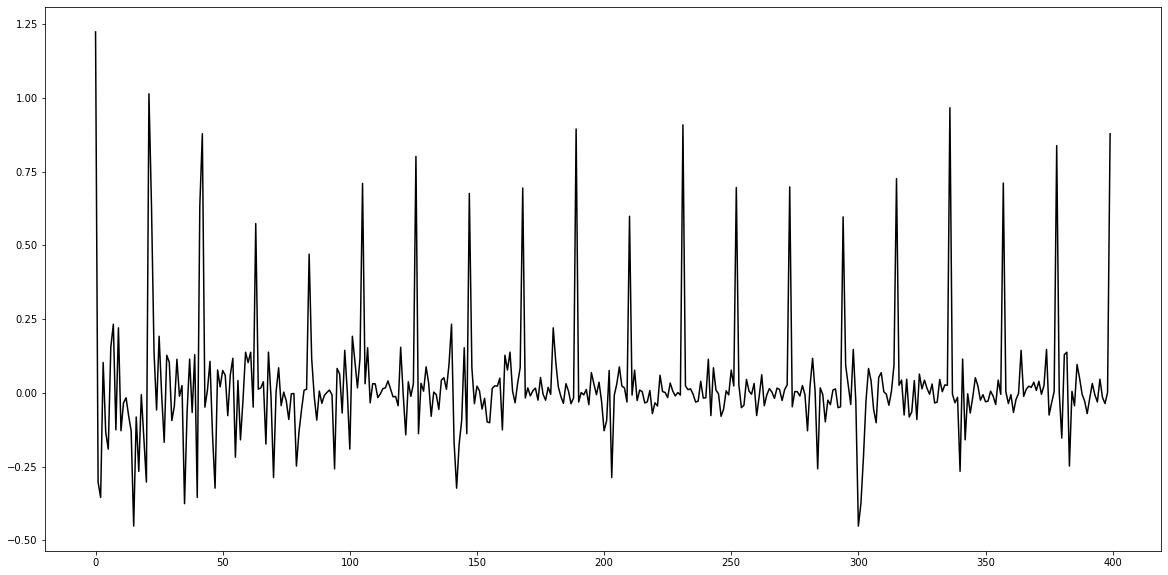

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

idx = 50

ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), tgl.emp_inv[idx].flatten(), color='k', label=r'Empirical Inverse')
for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), pre[i][idx].flatten(), color='r', alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}'.format(i))
# for i in [2.]:    
#     ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), res[i][3][idx].flatten(), color='g', alpha=0.5,
#             label=r'Constraint TGL ADMM CVX, Div = {}'.format(i))
ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), pre_grad[idx].flatten(), color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient')
ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), pre_tp[idx].flatten(), color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear')
ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), pre_[idx].flatten(), color='y', label=r'Vanilla TGL')


fig.legend(fontsize=15)
ax.set_ylabel('Values', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Entries', fontsize=15)
ax.set_title(r'Precisions at t={} for Empirical Inverse, TGL and Constraint TGL SCS/ADMM'.format(idx), fontsize=20)
plt.tight_layout()
plt.savefig('pre_{}_{}_{}_admm_relax_taylor.pdf'.format(idx, dim_X, dim_fac))

KeyError: 1.0791741799297781e-06

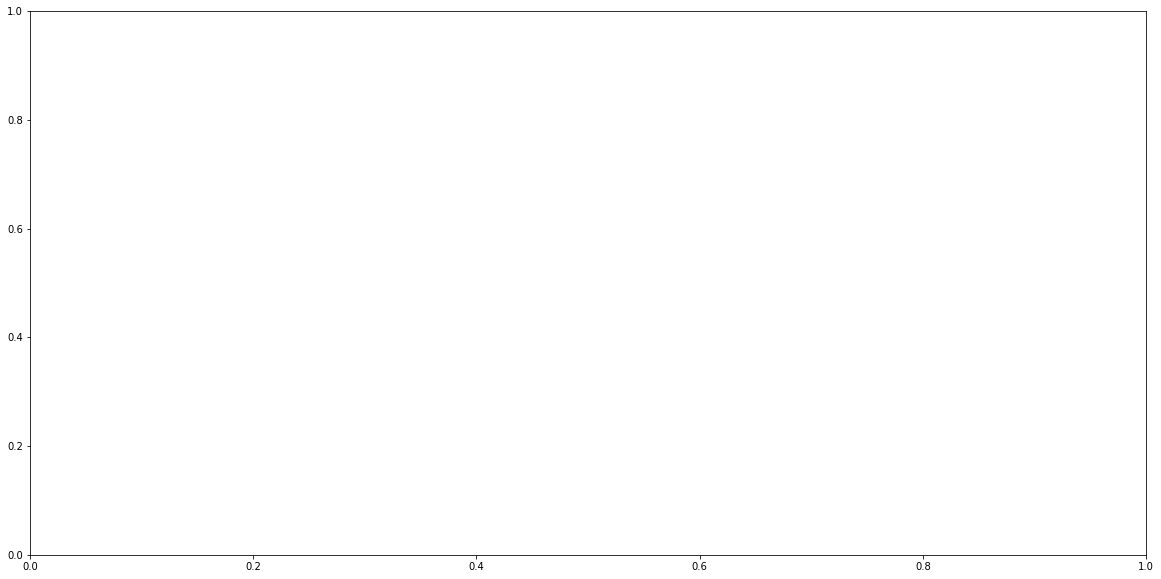

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    diff = (pre[i] -  pre_cvx).flatten()
    ax.hist(diff, bins=100, color='r', alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}'.format(i))
# for i in [2.]:    
#     diff = (res[i][3] -  pre_cvx).flatten()
#     ax.hist(diff, bins=50, color='g', alpha=0.2,
#             label=r'Constraint TGL ADMM CVX, Div = {}'.format(i))
diff = (pre_grad -  pre_cvx).flatten()
ax.hist(diff, bins=100, color='m', alpha=0.2,
        label=r'Constraint TGL ADMM Gradient')
diff = (pre_tp -  pre_cvx).flatten()
ax.hist(diff, bins=100, color='g', alpha=0.2,
        label=r'Constraint TGL ADMM Linear')
# diff = (pre_ -  pre_cvx).flatten()
# ax.hist(diff, bins=100, color='y', alpha=0.5, 
#         label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Values', fontsize=15)
major_loc = MultipleLocator(base=0.05)
ax.xaxis.set_major_locator(major_loc)
ax.set_xlim((-0.2, 0.2))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(r'Difference in Precisions for TGL and Constraint TGL SCS/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('pre_diff_hist_{}_{}_taylor.pdf'.format(dim_X, dim_fac))

KeyError: 1.0791741799297781e-06

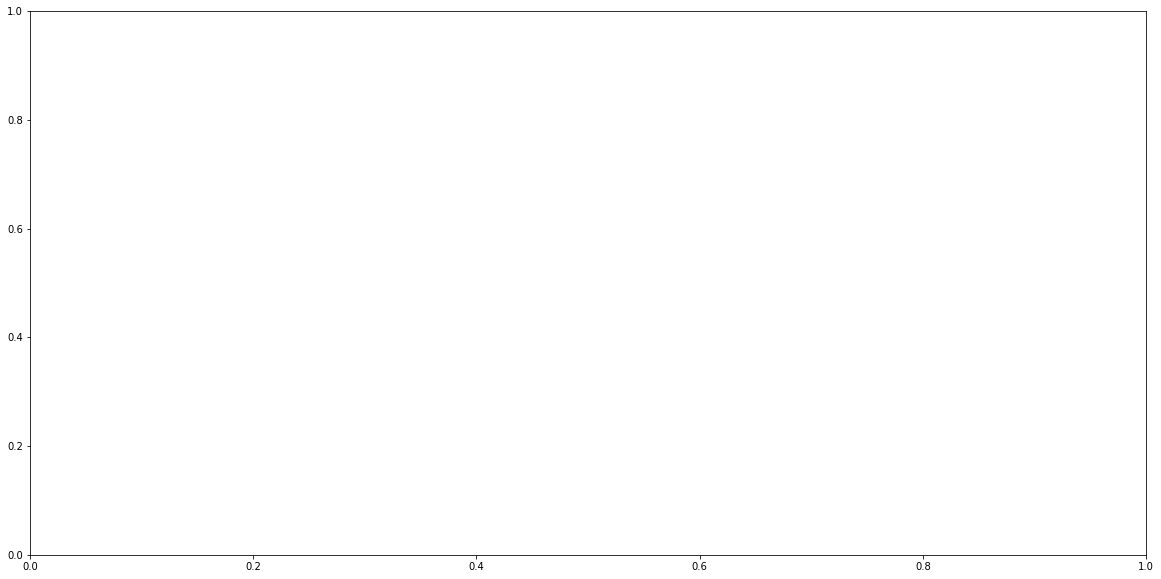

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    diff = (pre[i] -  tgl.emp_inv).flatten()
    ax.hist(diff, bins=100, color='r', alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}'.format(i))
# for i in [2.]:    
#     diff = (res[i][3] -  pre_cvx).flatten()
#     ax.hist(diff, bins=50, color='g', alpha=0.2,
#             label=r'Constraint TGL ADMM CVX, Div = {}'.format(i))
diff = (pre_grad -  tgl.emp_inv).flatten()
ax.hist(diff, bins=100, color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient')
diff = (pre_tp -  tgl.emp_inv).flatten()
ax.hist(diff, bins=100, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear')
# diff = (pre_ -  tgl.emp_inv).flatten()
# ax.hist(diff, bins=100, color='y', alpha=0.5, 
#         label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Values', fontsize=15)
# major_loc = MultipleLocator(base=0.05)
# ax.xaxis.set_major_locator(major_loc)
ax.set_xlim((-1.5, 1.5))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(r'Difference from Empirical Precisions for TGL and Constraint TGL SCS/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('pre_emp_diff_hist_{}_{}_taylor.pdf'.format(dim_X, dim_fac))

KeyError: 1.0791741799297781e-06

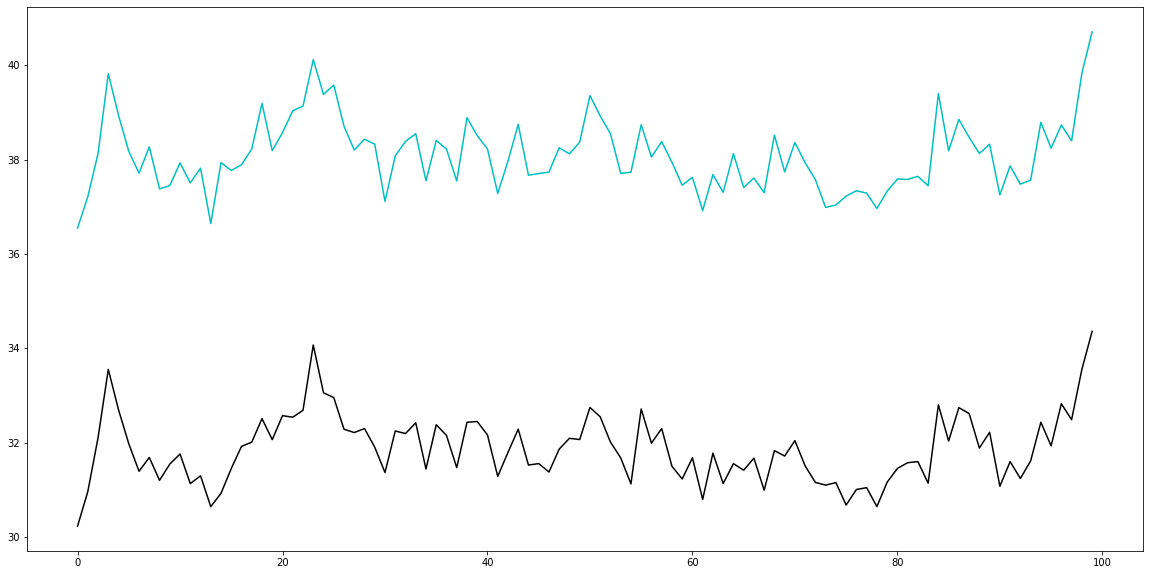

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(X_cov.shape[-1]), res[1][0], color='k', label=r'Empirical Inverse')
ax.plot(range(X_cov.shape[-1]), res[1][1], color='c', label=r'Constraint')
for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
    ax.plot(range(X_cov.shape[-1]), fit_score[i], color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), fit_score[i], color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# # for i in [2.]:    
# #     mean_diff = np.mean(np.array(res[i][2]) - res[i][1])
# #     ax.plot(range(X_cov.shape[-1]), res[i][2], alpha=0.5, color='g',
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
# # mean_diff = np.mean(np.array(fit_score_diff) - baseline_score)
# # ax.plot(range(n_time), fit_score_diff, alpha=0.5,
# #         label=r'Constraint TGL ADMM Difference, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_grad) - baseline_score_grad)
# ax.plot(range(X_cov.shape[-1]), fit_score_grad, alpha=0.5, color='m',
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_tp) - baseline_score_tp)
print(np.sum((np.array(fit_score_tp) - baseline_score_tp) > 0.01))
ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_) - res[1][1])
print(np.sum((np.array(fit_score_) - res[1][1]) > 0.01))
ax.plot(range(X_cov.shape[-1]), fit_score_, color='y', label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(mean_diff))

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL SCS/ADMM', fontsize=20)
# ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
plt.savefig('diff_like_{}_{}_admm_taylor.pdf'.format(dim_X, dim_fac))
# plt.savefig('diff_like_{}_{}_scs.pdf'.format(dim_X, dim_fac))

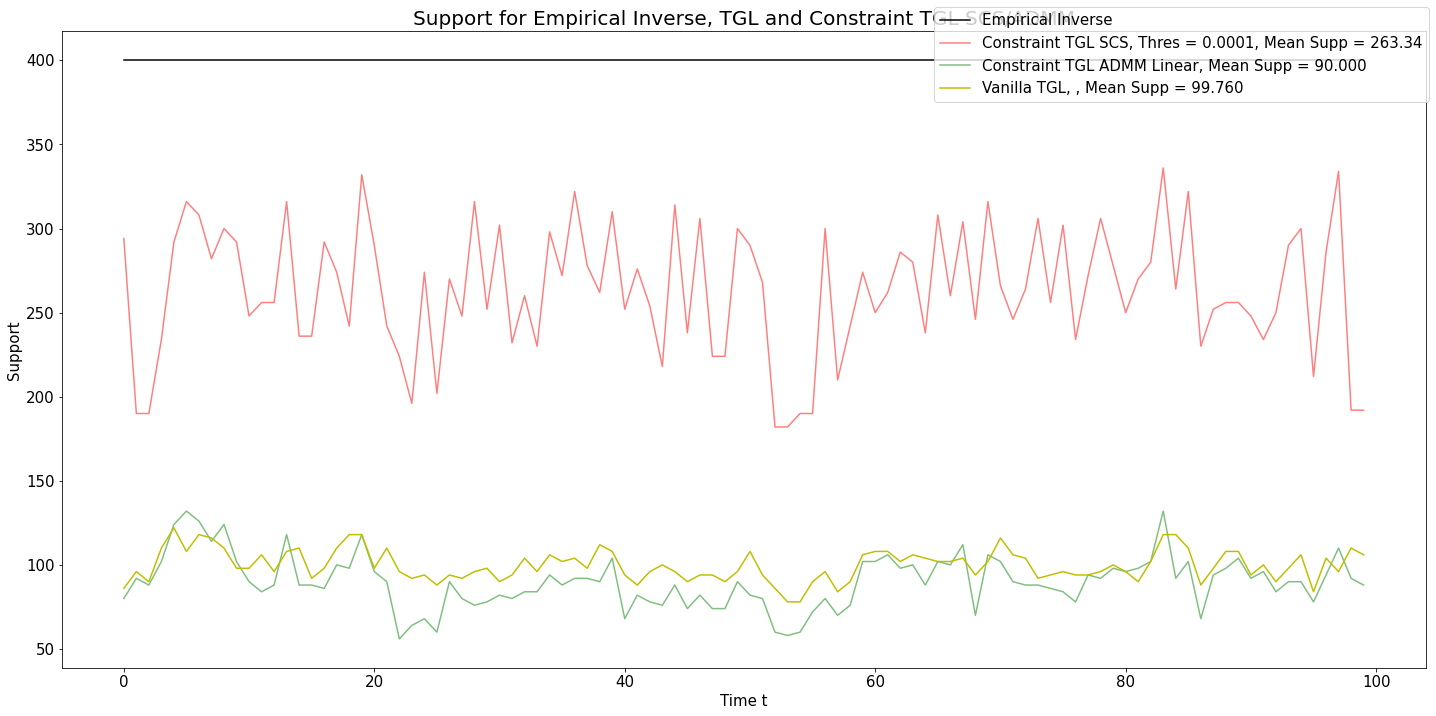

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(tgl.emp_inv[k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    supp = [sum(sum(abs(pre[i][t]) > 0)) for t in range(X_cov.shape[-1])]
    mean_supp = np.mean(supp)
    ax.plot(range(X_cov.shape[-1]), supp, color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), supp, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}, Mean Supp = {}'.format(i, mean_supp))
    color_index += 1
# # for i in [2.]:    
# #     supp = [sum(sum(abs(res[i][3][t]) > 0)) for t in range(X_cov.shape[-1])]
# #     mean_supp = np.mean(supp)
# #     ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Supp = {:.3f}'.format(i, mean_supp))
# supp = [sum(sum(abs(pre_grad[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(pre_[k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='y', label=r'Vanilla TGL, , Mean Supp = {:.3f}'.format(np.mean(supp)))


fig.legend(fontsize=15)
ax.set_ylabel('Support', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL SCS/ADMM', fontsize=20)
# ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
plt.savefig('diff_supp_{}_{}_admm_taylor.pdf'.format(dim_X, dim_fac))
# plt.savefig('diff_supp_{}_{}_scs.pdf'.format(dim_X, dim_fac))

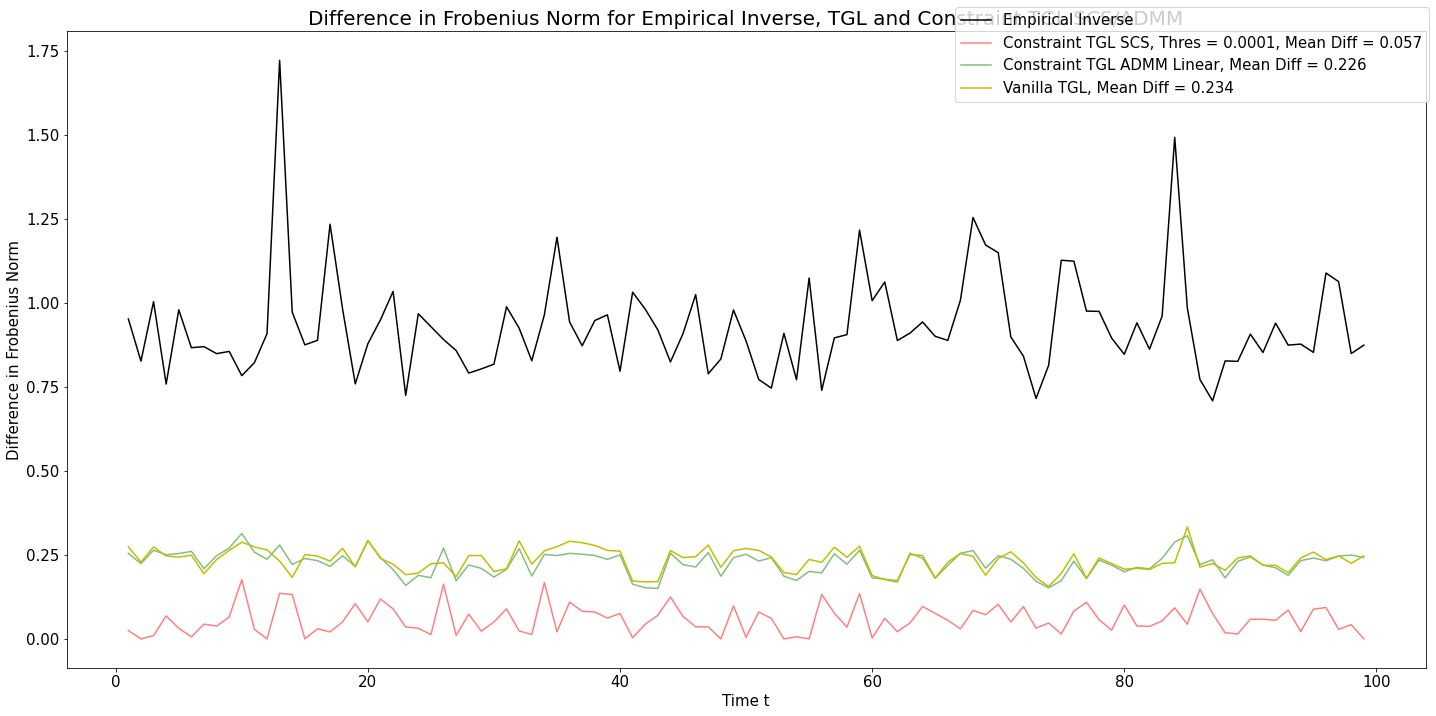

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

diff_emp = [norm(tgl.emp_inv[t] - tgl.emp_inv[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    diff = [norm(pre[i][t] - pre[i][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# # for i in [2.]:    
# #     diff_cvx = [norm(res[i][3][t] - res[i][3][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# #     ax.plot(range(1, X_cov.shape[-1]), diff_cvx, color='g', alpha=0.5,
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, np.mean(diff_cvx)))
# diff_grad = [norm(pre_grad[t] - pre_grad[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [norm(pre_[t] - pre_[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

        
fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL SCS/ADMM', fontsize=20)
# ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
plt.savefig('diff_fro_{}_{}_admm_taylor.pdf'.format(dim_X, dim_fac))
# plt.savefig('diff_fro_{}_{}_scs.pdf'.format(dim_X, dim_fac))